In [1]:
%load_ext autoreload
%autoreload 2
import copy
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro import poutine, infer, nn, optim, distributions as dist
plt.style.use('seaborn-v0_8')

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(5690)
N, D = 100, 50
x = torch.empty(N, D).uniform_(-100., 100.)
sigma = torch.distributions.LogNormal(0, 2.).sample((N,)).log()
theta_loc = torch.empty(D).uniform_(0., 50.).log()
theta_scale = torch.distributions.LogNormal(10, 5.).sample((D,))
theta =  torch.distributions.Normal(  theta_loc, theta_scale).sample().abs().clip(max=3e5).log()
# y = torch.distributions.LogNormal(((x - x.mean(0)) / x.var(0)) @ theta, sigma).sample()
y = ((x - x.mean(0)) / x.var(0)) @ theta  + sigma * torch.randn(N,)
y

tensor([ 1.0877e-01,  3.5261e+00,  2.8876e+00,  1.1733e+00, -7.3938e-01,
         1.1742e-01,  6.7918e-03,  1.2930e+00, -1.0407e-01, -1.3985e+00,
         7.0577e-01, -4.2529e-01, -5.1524e-01, -2.6984e+00, -1.2882e+00,
         9.1676e+00, -2.2871e+00,  8.9556e-01,  2.2848e+00,  3.0119e-01,
         3.0895e+00,  1.6176e+00,  1.6712e+00,  2.0958e+00, -1.0069e+00,
         3.1579e+00, -2.7435e+00,  5.5338e-01,  8.7988e-01,  8.2318e-01,
         2.0222e+00, -3.6755e+00,  7.7397e-01, -8.9992e-01, -5.3019e-01,
        -2.0714e+00,  4.7878e+00,  9.5117e-01,  4.3034e+00,  1.8038e-01,
        -2.0131e+00, -3.5648e+00, -1.1945e-01,  1.1780e+00,  2.3426e+00,
        -1.2809e+00, -4.2522e-02, -5.7136e+00, -2.3114e+00,  1.2990e+00,
        -2.1407e+00,  7.9455e-01, -1.9678e-01, -1.1012e+00,  3.3865e+00,
        -9.9359e-01,  2.3381e+00,  8.6036e+00,  5.1996e-01,  3.1674e-01,
         1.2306e+00,  4.2485e-01, -2.4577e+00, -3.6990e+00, -1.7309e+00,
         6.8014e+00, -4.9023e+00,  9.6114e-01,  1.6

In [3]:
data = {"x": x, "y": y}

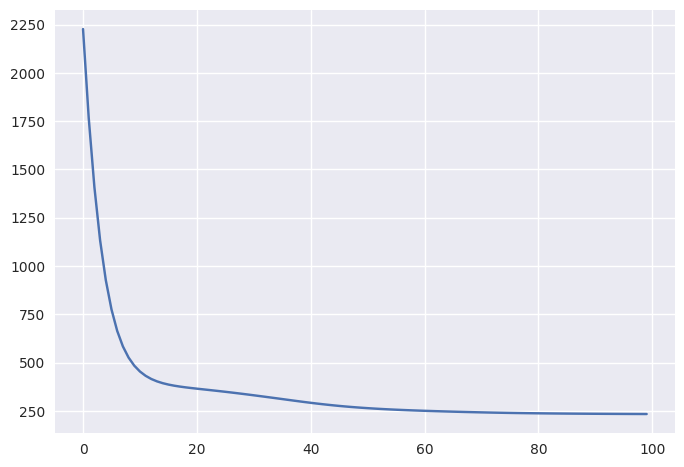

In [4]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(D, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, D),
        torch.nn.Softplus()
        )
    def forward(self, x):
        x = self.net(x)
        mu = x.mean(1)
        return mu
        
        
def linear_reg_model1(data, model):
    pyro.module("net", model)
    with pyro.plate("data", N):
        obs = pyro.sample("obs",
                        dist.Normal(model(data["x"]), torch.tensor(1.0)),
                        obs=data.get("y")
        )  
    return obs

pyro.clear_param_store()
torch.manual_seed(0)
pyro.set_rng_seed(0)
model = Model()
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_model1, lambda d, m: None, 
          opt, Trace_ELBO())
losses = []
for i in range(100):
    loss = svi.step(data, model)
    losses.append(loss)
plt.plot(losses)

In [5]:
param_store = pyro.get_param_store()

In [6]:
list(param_store.keys())

['net$$$net.0.weight',
 'net$$$net.0.bias',
 'net$$$net.2.weight',
 'net$$$net.2.bias']

In [7]:
pred = infer.Predictive(svi.model, guide=svi.guide, num_samples=1000)
d = {"x": x}
with torch.no_grad():
    yhat = pred(d, model)["obs"].mean(0)
yhat

tensor([ 1.5717e-01,  3.4873e+00,  2.7734e+00,  1.2926e+00,  5.0146e-02,
         4.5051e-01,  2.1431e-01,  1.2267e+00,  1.8164e-01,  2.1734e-02,
         7.9474e-01,  1.3049e-01,  2.5256e-02, -8.0654e-02, -1.1288e-02,
         9.0154e+00, -6.7341e-03,  6.5484e-01,  1.9015e+00,  4.3861e-01,
         2.9349e+00,  1.5572e+00,  1.7593e+00,  2.0678e+00,  6.6884e-03,
         3.0068e+00, -2.0296e-02,  6.9482e-01,  9.4520e-01,  8.7607e-01,
         2.0655e+00,  2.3082e-02,  9.2295e-01,  9.0848e-03,  1.7785e-02,
        -7.2887e-02,  4.8581e+00,  6.8093e-01,  4.2585e+00,  4.8685e-01,
         2.3593e-03, -1.5506e-02,  9.0809e-02,  9.9937e-01,  2.1133e+00,
        -5.2749e-02,  2.2931e-01,  1.8139e-02,  5.6105e-03,  1.1815e+00,
        -1.5070e-02,  8.9642e-01, -1.4768e-02,  3.7728e-02,  1.8432e+00,
         2.3132e-02,  2.2044e+00,  8.4761e+00,  6.2718e-01,  5.6720e-01,
         1.2534e+00,  3.8537e-01,  8.4223e-03,  6.6981e-03, -1.5706e-02,
         6.8063e+00, -6.0999e-02,  9.1812e-01,  1.4

In [8]:
y

tensor([ 1.0877e-01,  3.5261e+00,  2.8876e+00,  1.1733e+00, -7.3938e-01,
         1.1742e-01,  6.7918e-03,  1.2930e+00, -1.0407e-01, -1.3985e+00,
         7.0577e-01, -4.2529e-01, -5.1524e-01, -2.6984e+00, -1.2882e+00,
         9.1676e+00, -2.2871e+00,  8.9556e-01,  2.2848e+00,  3.0119e-01,
         3.0895e+00,  1.6176e+00,  1.6712e+00,  2.0958e+00, -1.0069e+00,
         3.1579e+00, -2.7435e+00,  5.5338e-01,  8.7988e-01,  8.2318e-01,
         2.0222e+00, -3.6755e+00,  7.7397e-01, -8.9992e-01, -5.3019e-01,
        -2.0714e+00,  4.7878e+00,  9.5117e-01,  4.3034e+00,  1.8038e-01,
        -2.0131e+00, -3.5648e+00, -1.1945e-01,  1.1780e+00,  2.3426e+00,
        -1.2809e+00, -4.2522e-02, -5.7136e+00, -2.3114e+00,  1.2990e+00,
        -2.1407e+00,  7.9455e-01, -1.9678e-01, -1.1012e+00,  3.3865e+00,
        -9.9359e-01,  2.3381e+00,  8.6036e+00,  5.1996e-01,  3.1674e-01,
         1.2306e+00,  4.2485e-01, -2.4577e+00, -3.6990e+00, -1.7309e+00,
         6.8014e+00, -4.9023e+00,  9.6114e-01,  1.6

In [9]:
((y - yhat) * 100 / y ).abs().long()

tensor([  44,    1,    3,   10,  106,  283, 3055,    5,  274,  101,   12,  130,
         104,   97,   99,    1,   99,   26,   16,   45,    5,    3,    5,    1,
         100,    4,   99,   25,    7,    6,    2,  100,   19,  101,  103,   96,
           1,   28,    1,  169,  100,   99,  176,   15,    9,   95,  639,  100,
         100,    9,   99,   12,   92,  103,   45,  102,    5,    1,   20,   79,
           1,    9,  100,  100,   99,    0,   98,    4,   14,    9,    6,    4,
         125,   33,   99,   96,   98,    2,   98,    0,   17,   20,  213,  111,
         101,   11,    1,  102,  105,   20,   13,    0,  182,  199,   45,  100,
           3,    5,   95,  100])

In [10]:
lin = torch.nn.Linear(10, 5)

In [11]:
lin.weight, lin.bias

(Parameter containing:
 tensor([[ 0.2802,  0.1019,  0.1193, -0.2663,  0.0730,  0.0116,  0.2703,  0.1169,
          -0.1021, -0.0677],
         [ 0.1458, -0.0775, -0.0734,  0.3030, -0.3066, -0.0344,  0.1878,  0.2673,
          -0.0480,  0.1538],
         [ 0.0221, -0.1502, -0.0319, -0.0243, -0.1645,  0.0376, -0.0517,  0.2865,
          -0.0848,  0.2062],
         [-0.2990, -0.0369, -0.1698,  0.1406, -0.1674,  0.2984, -0.2488, -0.0579,
           0.0864,  0.1769],
         [-0.2248, -0.2146, -0.1994,  0.2812, -0.1385, -0.1413,  0.2149,  0.2360,
           0.0625, -0.0119]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2653,  0.2840,  0.2537,  0.1645, -0.3001], requires_grad=True))

In [12]:
pyro.nn.module.to_pyro_module_(lin)

In [13]:
lin

PyroLinear(in_features=10, out_features=5, bias=True)

In [14]:
type(lin.weight)

torch.nn.parameter.Parameter

In [15]:
model.net[0].weight

Parameter containing:
tensor([[-0.0077,  0.0410, -0.1020,  ...,  0.0491, -0.0496,  0.0088],
        [ 0.1159,  0.1459,  0.0552,  ..., -0.0149, -0.1043, -0.1005],
        [ 0.1528,  0.1215, -0.0224,  ...,  0.0113, -0.0791, -0.1339],
        ...,
        [ 0.0377,  0.1486,  0.0751,  ..., -0.1096, -0.0631, -0.0761],
        [ 0.0383, -0.0826,  0.0867,  ..., -0.0365, -0.0457, -0.0527],
        [ 0.0290, -0.0055, -0.0506,  ..., -0.0116,  0.0244, -0.0953]],
       requires_grad=True)

In [16]:
list(param_store.keys())

['net$$$net.0.weight',
 'net$$$net.0.bias',
 'net$$$net.2.weight',
 'net$$$net.2.bias']

Parameter containing:
tensor([[-0.0011,  0.0759, -0.1164,  ...,  0.0829, -0.0627, -0.0051],
        [ 0.0904,  0.1406,  0.0561,  ...,  0.0296, -0.1103, -0.0814],
        [ 0.1330,  0.0953, -0.0617,  ..., -0.0009, -0.0703, -0.1084],
        ...,
        [ 0.0054,  0.1320,  0.0578,  ..., -0.0691, -0.0381, -0.0572],
        [ 0.0624, -0.0567,  0.0480,  ..., -0.0891, -0.0562, -0.0971],
        [ 0.0457,  0.0036, -0.0194,  ..., -0.0601,  0.0047, -0.1094]],
       requires_grad=True)


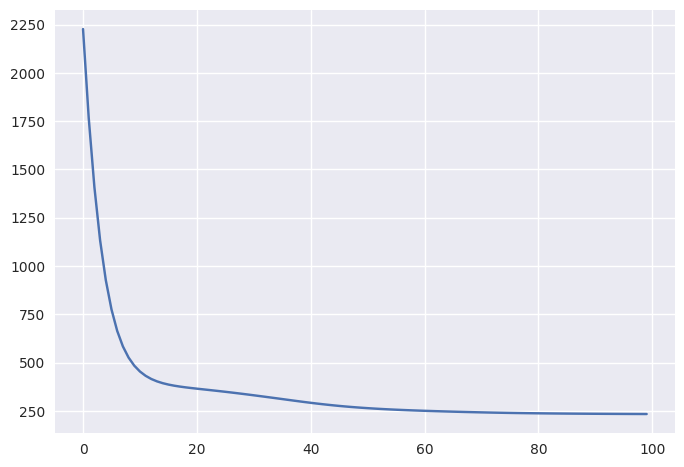

In [17]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(D, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, D),
        torch.nn.Softplus()
        )
    def forward(self, x):
        x = self.net(x)
        mu = x.mean(1)
        return mu
        
        
def linear_reg_model1(data, model):
    pyro.module("net", model)
    with pyro.plate("data", N):
        obs = pyro.sample("obs",
                        dist.Normal(model(data["x"]), torch.tensor(1.0)),
                        obs=data.get("y")
        )  
    return obs

pyro.clear_param_store()
torch.manual_seed(0)
pyro.set_rng_seed(0)
model = Model()
pyro.nn.module.to_pyro_module_(model)
print(model.net[0].weight)
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_model1, lambda d, m: None, 
          opt, Trace_ELBO())
losses = []
for i in range(100):
    loss = svi.step(data, model)
    losses.append(loss)
plt.plot(losses)

In [18]:
print(model.net[0].weight)

Parameter containing:
tensor([[-0.0077,  0.0410, -0.1020,  ...,  0.0491, -0.0496,  0.0088],
        [ 0.1159,  0.1459,  0.0552,  ..., -0.0149, -0.1043, -0.1005],
        [ 0.1528,  0.1215, -0.0224,  ...,  0.0113, -0.0791, -0.1339],
        ...,
        [ 0.0377,  0.1486,  0.0751,  ..., -0.1096, -0.0631, -0.0761],
        [ 0.0383, -0.0826,  0.0867,  ..., -0.0365, -0.0457, -0.0527],
        [ 0.0290, -0.0055, -0.0506,  ..., -0.0116,  0.0244, -0.0953]],
       requires_grad=True)


In [19]:
print(model.net[0].weight)

Parameter containing:
tensor([[-0.0077,  0.0410, -0.1020,  ...,  0.0491, -0.0496,  0.0088],
        [ 0.1159,  0.1459,  0.0552,  ..., -0.0149, -0.1043, -0.1005],
        [ 0.1528,  0.1215, -0.0224,  ...,  0.0113, -0.0791, -0.1339],
        ...,
        [ 0.0377,  0.1486,  0.0751,  ..., -0.1096, -0.0631, -0.0761],
        [ 0.0383, -0.0826,  0.0867,  ..., -0.0365, -0.0457, -0.0527],
        [ 0.0290, -0.0055, -0.0506,  ..., -0.0116,  0.0244, -0.0953]],
       requires_grad=True)


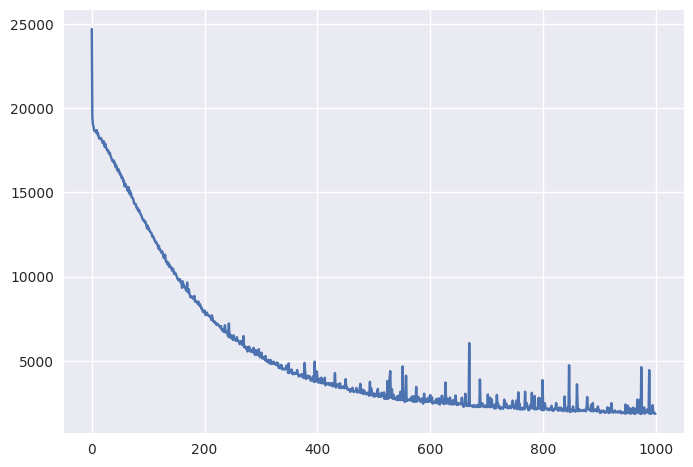

In [20]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(D, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, D),
        torch.nn.Softplus()
        )
    def forward(self, x, m=None):
        if m is None:
            m = self
        x = self.net(x)
        mu = x.mean(1)
        return mu
        
        
def linear_reg_model1(data, model):
    pyro.module("net", model)
    mu = model(data["x"]) 
    with pyro.plate("data", N):
        obs = pyro.sample("obs", dist.Normal(mu, torch.tensor(1.0)) , obs=data.get("y")
        )  
    return obs

pyro.clear_param_store()
torch.manual_seed(0)
pyro.set_rng_seed(0)
model = Model()
pyro.nn.module.to_pyro_module_(model)
for net in model.children():
    for m in net.children():
        if isinstance(m, torch.nn.Linear):
            m.weight = nn.PyroSample(dist.Normal(0., 1.).expand([m.weight.shape[0],
                                                                 m.weight.shape[1]]).to_event(m.weight.dim()))
            if m.bias is not None:
                m.bias = nn.PyroSample(dist.Normal(0., 1.).expand([m.bias.shape[0]]).to_event(m.bias.dim()))
opt = optim.Adam({"lr": 1e-2})
svi = SVI(linear_reg_model1, 
          infer.autoguide.AutoNormal(linear_reg_model1), 
          opt, Trace_ELBO())
losses = []
for i in range(1000):
    loss = svi.step(data, model)
    losses.append(loss)
plt.plot(losses)

In [21]:
model.net[0].weight.size()

torch.Size([100, 50])

In [22]:
model.net[0].weight

tensor([[-0.0913,  0.7154,  0.0153,  ...,  0.6627,  0.6407,  0.2832],
        [ 0.0396,  0.3011,  0.9108,  ...,  1.4573, -0.8347,  0.8353],
        [-0.4927,  1.4999,  0.7379,  ...,  0.1464, -1.4155, -2.2136],
        ...,
        [-1.3920,  0.8843, -0.0383,  ...,  0.9240, -0.1004,  0.0560],
        [ 0.7941,  3.9973, -0.1439,  ...,  0.1303, -0.4810,  0.2846],
        [ 0.2130,  0.3771,  1.2480,  ...,  0.9110, -1.0817,  0.5581]])

In [23]:
pred = infer.Predictive(svi.model, guide=svi.guide, num_samples=1000)
d = {"x": x}
with torch.no_grad():
    yhat = pred(d, model)["obs"].mean(0)
yhat

tensor([ 0.0757,  0.1416,  0.3064, -0.0105,  0.0272,  0.2092,  0.1638,  0.1289,
         0.0662,  0.1122,  0.1070,  0.1245,  0.1500,  0.1067,  0.0910,  0.2398,
         0.2789,  0.2021,  0.0580,  0.0647,  0.0841,  0.1717,  0.0802,  0.0978,
         0.1652,  0.0956,  0.0782,  0.0771,  0.2629,  0.2459,  0.0763,  0.2753,
         0.2929,  0.1346,  0.1159,  0.1030,  0.1442,  0.2694,  0.1712,  0.1429,
         0.1351,  0.2834,  0.1766,  0.1403,  0.1520,  0.1829,  0.1699,  0.2947,
         0.2320,  0.0526,  0.0563,  0.1822,  0.2501,  0.1353,  0.0773,  0.0663,
         0.1958,  0.1142,  0.1682,  0.1108,  0.1202,  0.0452,  0.0857,  0.0622,
         0.1494,  0.1937,  0.0765,  0.0882,  0.1192,  0.0459,  0.3907,  0.0248,
         0.1713,  0.1943,  0.1072,  0.0863,  0.2499,  0.0620,  0.0894,  0.1053,
         0.1017,  0.0634,  0.1274,  0.0768,  0.1392,  0.4751,  0.1399,  0.0377,
         0.1577,  0.1828,  0.0978,  0.2281,  0.0894,  0.2352,  0.1495,  0.0591,
         0.0663,  0.1758,  0.1356,  0.07

In [24]:
y

tensor([ 1.0877e-01,  3.5261e+00,  2.8876e+00,  1.1733e+00, -7.3938e-01,
         1.1742e-01,  6.7918e-03,  1.2930e+00, -1.0407e-01, -1.3985e+00,
         7.0577e-01, -4.2529e-01, -5.1524e-01, -2.6984e+00, -1.2882e+00,
         9.1676e+00, -2.2871e+00,  8.9556e-01,  2.2848e+00,  3.0119e-01,
         3.0895e+00,  1.6176e+00,  1.6712e+00,  2.0958e+00, -1.0069e+00,
         3.1579e+00, -2.7435e+00,  5.5338e-01,  8.7988e-01,  8.2318e-01,
         2.0222e+00, -3.6755e+00,  7.7397e-01, -8.9992e-01, -5.3019e-01,
        -2.0714e+00,  4.7878e+00,  9.5117e-01,  4.3034e+00,  1.8038e-01,
        -2.0131e+00, -3.5648e+00, -1.1945e-01,  1.1780e+00,  2.3426e+00,
        -1.2809e+00, -4.2522e-02, -5.7136e+00, -2.3114e+00,  1.2990e+00,
        -2.1407e+00,  7.9455e-01, -1.9678e-01, -1.1012e+00,  3.3865e+00,
        -9.9359e-01,  2.3381e+00,  8.6036e+00,  5.1996e-01,  3.1674e-01,
         1.2306e+00,  4.2485e-01, -2.4577e+00, -3.6990e+00, -1.7309e+00,
         6.8014e+00, -4.9023e+00,  9.6114e-01,  1.6

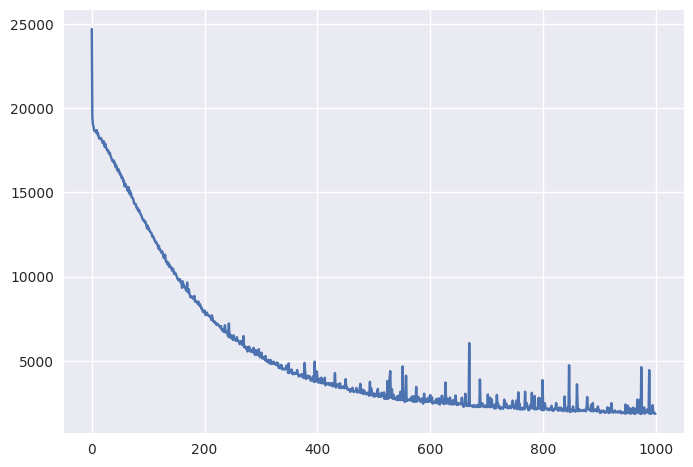

In [25]:
class Model(nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(D, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, D),
        torch.nn.Softplus()
        )
    def forward(self, data, m=None):
        if m is None:
            m = self
        x = data["x"]
        x = self.net(x)
        mu = x.mean(1)
        with pyro.plate("data", N):
            obs = pyro.sample("obs", dist.Normal(mu, torch.tensor(1.0)) , obs=data.get("y")
            )  
        return obs

pyro.clear_param_store()
torch.manual_seed(0)
pyro.set_rng_seed(0)
model = Model()
pyro.nn.module.to_pyro_module_(model)
for net in model.children():
    for m in net.children():
        if isinstance(m, torch.nn.Linear):
            m.weight = nn.PyroSample(dist.Normal(0., 1.).expand([m.weight.shape[0],
                                                                 m.weight.shape[1]]).to_event(m.weight.dim()))
            if m.bias is not None:
                m.bias = nn.PyroSample(dist.Normal(0., 1.).expand([m.bias.shape[0]]).to_event(m.bias.dim()))
opt = optim.Adam({"lr": 1e-2})
svi = SVI(model, 
          infer.autoguide.AutoNormal(model), 
          opt, Trace_ELBO())
losses = []
for i in range(1000):
    loss = svi.step(data, model)
    losses.append(loss)
plt.plot(losses)